# Task 1

In [1]:
import numpy as np
from scipy.stats import norm, binom

# Define parameters for the credit portfolio
num_assets = 1000  # Number of credit assets in the portfolio
default_probabilities = np.random.uniform(0.01, 0.5, num_assets)  # Randomly generate default probabilities for each asset
correlation_matrix = np.random.uniform(-0.5, 0.5, size=(num_assets, num_assets))  # Randomly generate correlation matrix

# Calibrate the models to match expected loss and unexpected loss
expected_loss = np.sum(default_probabilities)  # Total expected loss for the portfolio

# For Gaussian Copula, we'll assume a constant standard deviation of loss
sigma_loss = 0.1 * expected_loss  # Assumed standard deviation for loss
unexpected_loss_gaussian = norm.ppf(0.999) * sigma_loss  # Calibrate to 99.9% confidence level

# For Binomial Expansion Model, we'll calculate the number of defaults necessary to match the unexpected loss
p_default = np.mean(default_probabilities)  # Probability of default for each asset
n_defaults = int(binom.ppf(0.999, num_assets, p_default))  # Number of defaults at 99.9% confidence level
unexpected_loss_binomial = n_defaults * expected_loss / num_assets  # Calibrate to 99.9% confidence level

# Generate loss distributions for both models
np.random.seed(0)  # Set seed for reproducibility

# Gaussian Copula model
loss_gaussian = np.random.normal(expected_loss, sigma_loss, size=10000)

# Binomial Expansion Model
loss_binomial = []
for _ in range(10000):
    defaults = np.random.choice([0, 1], size=num_assets, p=[1 - p_default, p_default])
    loss_binomial.append(np.sum(defaults) * expected_loss / num_assets)

# Compare loss distributions
print("Mean Loss (Gaussian Copula):", np.mean(loss_gaussian))
print("Mean Loss (Binomial Expansion Model):", np.mean(loss_binomial))
print("Unexpected Loss (Gaussian Copula):", np.percentile(loss_gaussian, 99.9))
print("Unexpected Loss (Binomial Expansion Model):", np.percentile(loss_binomial, 99.9))

Mean Loss (Gaussian Copula): 256.2311624811757
Mean Loss (Binomial Expansion Model): 65.90766464833567
Unexpected Loss (Gaussian Copula): 333.202247146207
Unexpected Loss (Binomial Expansion Model): 77.01156594106598


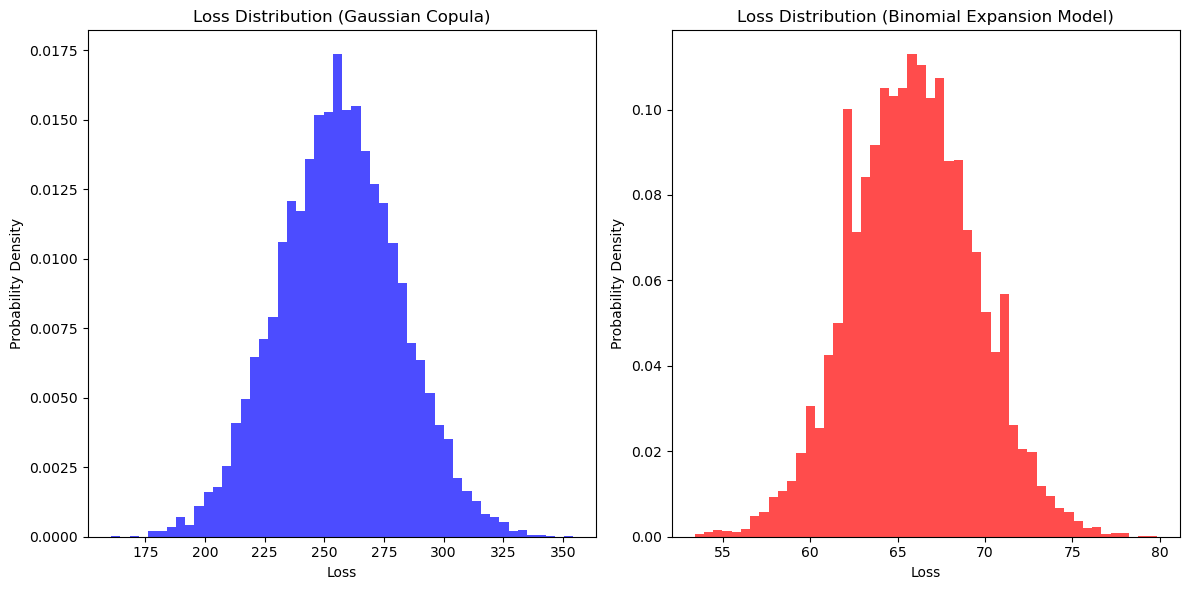

Statistical Properties (Gaussian Copula):
Mean Loss: 256.2311624811757
Standard Deviation: 25.351008086849077

Statistical Properties (Binomial Expansion Model):
Mean Loss: 65.90766464833567
Standard Deviation: 3.5402443010651687
Skewness: 0.04058136839253391
Kurtosis: 0.06474680025054536

Ratings:
Rating (Gaussian Copula): 3
Rating (Binomial Expansion Model): 3


In [5]:
import matplotlib.pyplot as plt

# Plot histograms of loss distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(loss_gaussian, bins=50, color='blue', alpha=0.7, density=True)
plt.title('Loss Distribution (Gaussian Copula)')
plt.xlabel('Loss')
plt.ylabel('Probability Density')

plt.subplot(1, 2, 2)
plt.hist(loss_binomial, bins=50, color='red', alpha=0.7, density=True)
plt.title('Loss Distribution (Binomial Expansion Model)')
plt.xlabel('Loss')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()

# Compare statistical properties of loss distributions
print("Statistical Properties (Gaussian Copula):")
print("Mean Loss:", np.mean(loss_gaussian))
print("Standard Deviation:", np.std(loss_gaussian))
#print("Skewness:", norm.stats(moments='s', loc=np.mean(loss_gaussian), scale=np.std(loss_gaussian))[0])
#print("Kurtosis:", norm.stats(moments='k', loc=np.mean(loss_gaussian), scale=np.std(loss_gaussian))[0])

print("\nStatistical Properties (Binomial Expansion Model):")
print("Mean Loss:", np.mean(loss_binomial))
print("Standard Deviation:", np.std(loss_binomial))
print("Skewness:", np.mean((loss_binomial - np.mean(loss_binomial))**3) / np.std(loss_binomial)**3)
print("Kurtosis:", np.mean((loss_binomial - np.mean(loss_binomial))**4) / np.std(loss_binomial)**4 - 3)

# Assign ratings based on loss distributions
thresholds = [0.005, 0.01, 0.02]  # Example rating thresholds for assigning AAA, AA, A ratings
rating_gaussian = np.sum(np.percentile(loss_gaussian, 99.9) > thresholds)
rating_binomial = np.sum(np.percentile(loss_binomial, 99.9) > thresholds)

print("\nRatings:")
print("Rating (Gaussian Copula):", rating_gaussian)
print("Rating (Binomial Expansion Model):", rating_binomial)

# Task 2

In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [34]:
def simulate_defaults_period_by_period(corr_matrix, num_periods, num_names):
    defaults = np.zeros((num_periods, num_names))
    for t in range(num_periods):
        if t == 0:
            defaults[t] = np.random.rand(num_names) > stats.norm.cdf(0, loc=0, scale=1)
        else:
            remaining_names = np.where(defaults[t-1] == 0)[0]  # Get indices of names that have not defaulted
            if len(remaining_names) == 0:
                break  # If all names have defaulted, stop simulation
            corr_matrix_remaining = corr_matrix[remaining_names][:, remaining_names]  # Extract relevant part of corr_matrix
            for i in range(len(remaining_names)):
                if defaults[t-1, remaining_names[i]] == 1:
                    continue  # Skip defaulted names
                corr_row = corr_matrix_remaining[i]
                defaults[t, remaining_names[i]] = np.random.rand() > stats.norm.cdf(0, loc=corr_row.mean(), scale=np.sqrt(corr_row.var()))
    return defaults

def simulate_defaults_gaussian_copula(corr_matrix, num_periods, num_names):
    defaults = np.zeros((num_periods, num_names))
    for t in range(num_periods):
        if t == 0:
            defaults[t] = np.random.rand(num_names) > stats.norm.cdf(0, loc=0, scale=1)
        else:
            prev_defaults = defaults[t-1]
            prev_defaults_corr = prev_defaults.reshape(-1, 1) @ prev_defaults.reshape(1, -1)
            corr_matrix_remaining = corr_matrix * (1 - prev_defaults_corr)
            defaults[t] = np.random.rand(num_names) > stats.norm.cdf(0, loc=0, scale=1)
    return defaults

In [35]:
def generate_corr_matrix(num_names, corr_coeff):
    corr_matrix = np.ones((num_names, num_names)) * corr_coeff
    np.fill_diagonal(corr_matrix, 1)
    return corr_matrix

In [52]:
defaults_gaussian_copula[0]

array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.])

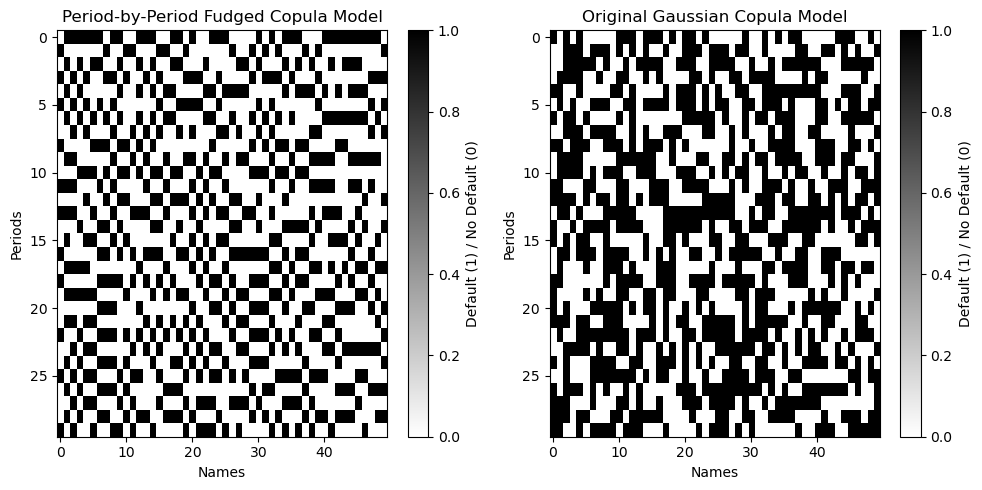

In [50]:
# Parameters
num_periods = 30
num_names = 50
corr_coeff = 0.05

# Generate correlation matrix
corr_matrix = generate_corr_matrix(num_names, corr_coeff)

# Simulate defaults using both approaches
defaults_period_by_period = simulate_defaults_period_by_period(corr_matrix, num_periods, num_names)
defaults_gaussian_copula = simulate_defaults_gaussian_copula(corr_matrix, num_periods, num_names)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(defaults_period_by_period, cmap='binary', aspect='auto')
plt.title('Period-by-Period Fudged Copula Model')
plt.xlabel('Names')
plt.ylabel('Periods')
plt.colorbar(label='Default (1) / No Default (0)')

plt.subplot(1, 2, 2)
plt.imshow(defaults_gaussian_copula, cmap='binary', aspect='auto')
plt.title('Original Gaussian Copula Model')
plt.xlabel('Names')
plt.ylabel('Periods')
plt.colorbar(label='Default (1) / No Default (0)')

plt.tight_layout()
plt.show()

In [38]:
corr_matrix

array([[1.  , 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 1.  , 0.05, ..., 0.05, 0.05, 0.05],
       [0.05, 0.05, 1.  , ..., 0.05, 0.05, 0.05],
       ...,
       [0.05, 0.05, 0.05, ..., 1.  , 0.05, 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 1.  , 0.05],
       [0.05, 0.05, 0.05, ..., 0.05, 0.05, 1.  ]])

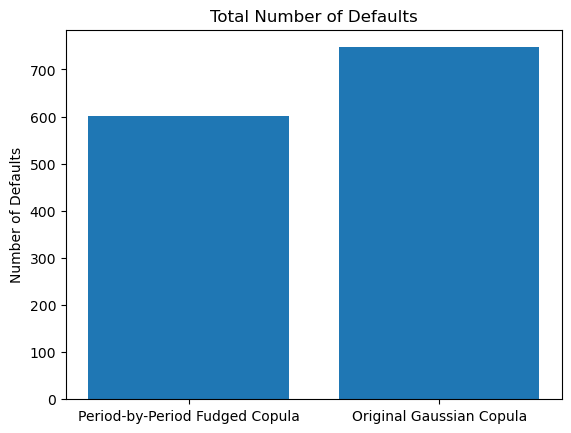

In [39]:
# Calculate total number of defaults for each approach
total_defaults_period_by_period = np.sum(defaults_period_by_period)
total_defaults_gaussian_copula = np.sum(defaults_gaussian_copula)

# Plotting
plt.bar(['Period-by-Period Fudged Copula', 'Original Gaussian Copula'], 
        [total_defaults_period_by_period, total_defaults_gaussian_copula])
plt.title('Total Number of Defaults')
plt.ylabel('Number of Defaults')
plt.show()